Árvore Binomial de Preços da Ação:
Passo 0:  ['125.00']
Passo 1:  ['114.63', '136.31']
Passo 2:  ['105.12', '125.00', '148.64']
Passo 3:  ['96.40', '114.63', '136.31', '162.09']
Passo 4:  ['88.40', '105.12', '125.00', '148.64', '176.75']
Passo 5:  ['81.07', '96.40', '114.63', '136.31', '162.09', '192.74']
Passo 6:  ['69.34', '83.40', '100.12', '120.00', '143.64', '171.75', '205.17']
Passo 7:  ['68.18', '81.07', '96.40', '114.63', '136.31', '162.09', '192.74', '229.19']
Passo 8:  ['62.52', '74.34', '88.40', '105.12', '125.00', '148.64', '176.75', '210.17', '249.92']


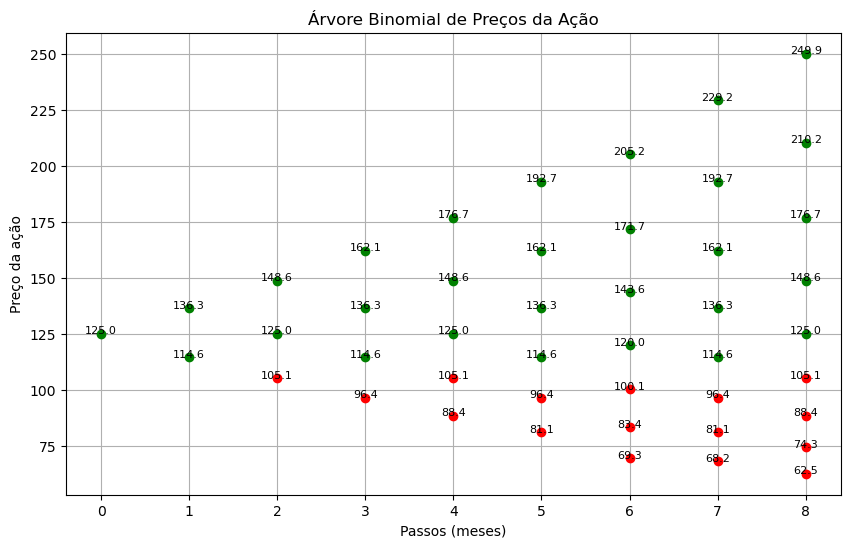


Preços das Opções no Início (t=0):
Put Europeia: 5.06
Call Europeia: 21.80
Put Americana: 6.14
Call Americana: 21.80


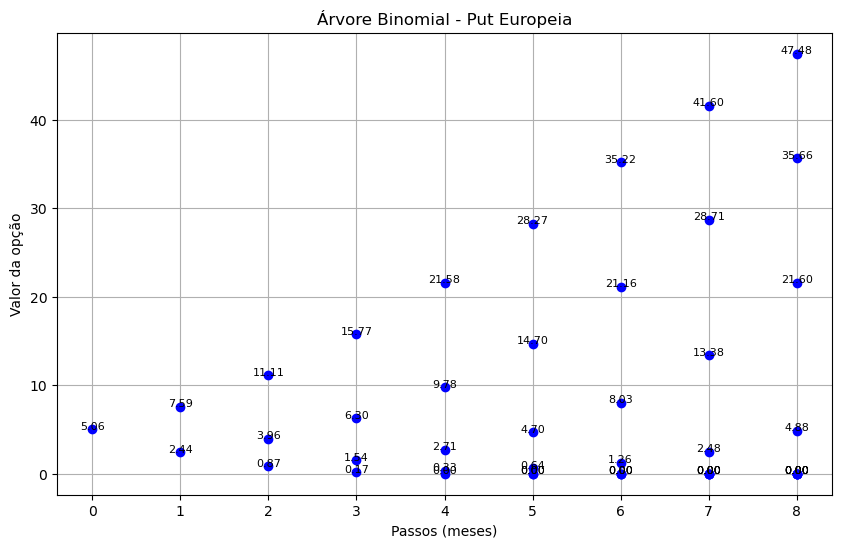

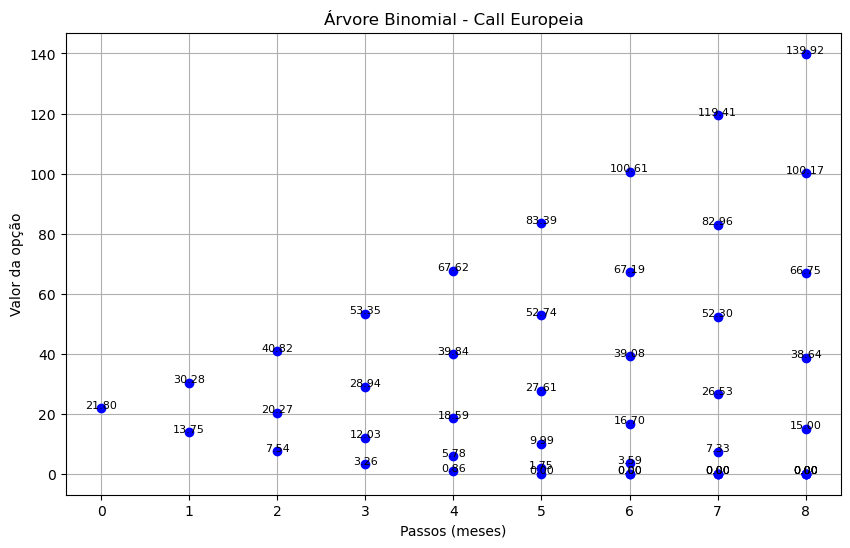

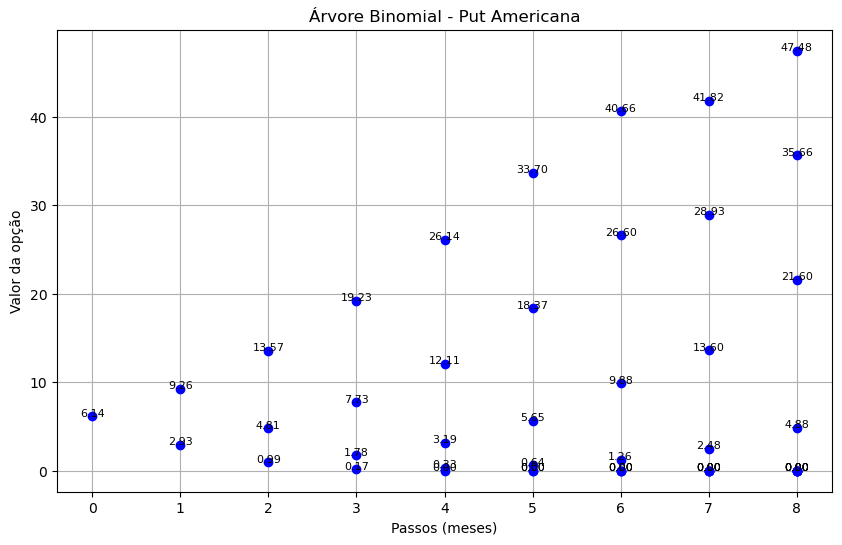

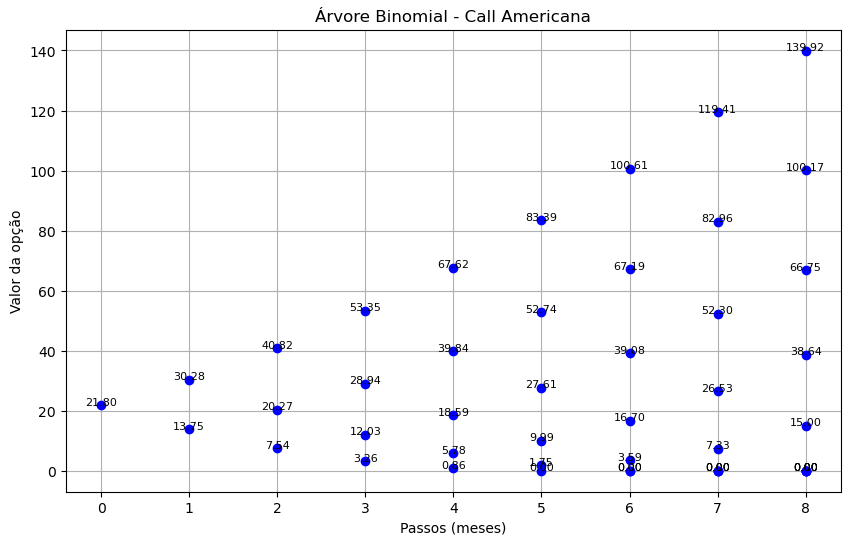


Diferenças entre Opções Europeias e Americanas:
Put: 1.0866 (Americana - Europeia)
Call: 0.0000 (Americana - Europeia)

Pontos de Exercício Antecipado (Put Americana):
Passo 6: Preço = 69.34, Valor Exercício = 40.66
Passo 6: Preço = 83.40, Valor Exercício = 26.60
Passo 6: Preço = 100.12, Valor Exercício = 9.88
Passo 7: Preço = 68.18, Valor Exercício = 41.82
Passo 7: Preço = 81.07, Valor Exercício = 28.93
Passo 7: Preço = 96.40, Valor Exercício = 13.60


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros iniciais
S0 = 125                    # Preço inicial da ação
T = 8 / 12                  # 8 meses em anos
N = 8                       # Número de passos (1 por mês)
r = 0.024                   # Taxa de juros anual
sigma = 0.30                # Volatilidade anual
q = 0                       # Taxa de dividendos contínua (dividendo pontual será aplicado)
tol_price = 110             # Preço mínimo tolerado (para análise visual)
dividend = 0.04 * S0        # Dividendo de 4% sobre o preço inicial (em 6 meses)
dividend_step = 6           # Passo correspondente ao 6º mês
K = 110                     # Strike da opção

# Intervalo de tempo por passo
dt = T / N

# Fatores de subida e descida (modelo CRR)
u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
p = (np.exp((r - q) * dt) - d) / (u - d)  # Probabilidade neutra ao risco

# Inicializa a árvore de preços da ação
stock_tree = np.zeros((N + 1, N + 1))
stock_tree[0, 0] = S0

# Preenche a árvore de preços
for i in range(1, N + 1):
    stock_tree[i, 0] = stock_tree[i - 1, 0] * d  # Movimento de baixa
    for j in range(1, i + 1):
        stock_tree[i, j] = stock_tree[i - 1, j - 1] * u  # Movimento de alta

# Aplica o dividendo no 6º mês (passo 6)
if dividend > 0:
    for j in range(0, dividend_step + 1):
        stock_tree[dividend_step, j] = max(stock_tree[dividend_step, j] - dividend, 0)

# Visualização da árvore de preços
print("Árvore Binomial de Preços da Ação:")
for i in range(N + 1):
    print(f"Passo {i}: ", ["{:.2f}".format(price) for price in stock_tree[i, :i+1]])

# Gráfico da árvore de preços
plt.figure(figsize=(10, 6))
for i in range(N + 1):
    for j in range(i + 1):
        color = 'red' if stock_tree[i, j] < tol_price else 'green'
        plt.plot(i, stock_tree[i, j], 'o', color=color)
        plt.text(i, stock_tree[i, j], f"{stock_tree[i, j]:.1f}", fontsize=8, ha='center')

plt.title("Árvore Binomial de Preços da Ação")
plt.xlabel("Passos (meses)")
plt.ylabel("Preço da ação")
plt.grid(True)
plt.show()

# Função para calcular opções europeias (Call e Put)
def european_option(stock_tree, K, option_type='put'):
    option_tree = np.zeros_like(stock_tree)
    
    # Payoff no vencimento
    for j in range(N + 1):
        if option_type == 'put':
            option_tree[N, j] = max(K - stock_tree[N, j], 0)
        else:  # call
            option_tree[N, j] = max(stock_tree[N, j] - K, 0)
    
    # Retropropagação
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_tree[i, j] = np.exp(-r * dt) * (
                p * option_tree[i + 1, j + 1] + (1 - p) * option_tree[i + 1, j]
            )
    
    return option_tree

# Função para calcular opções americanas (Call e Put)
def american_option(stock_tree, K, option_type='put'):
    option_tree = np.zeros_like(stock_tree)
    
    # Payoff no vencimento
    for j in range(N + 1):
        if option_type == 'put':
            option_tree[N, j] = max(K - stock_tree[N, j], 0)
        else:  # call
            option_tree[N, j] = max(stock_tree[N, j] - K, 0)
    
    # Retropropagação com verificação de exercício antecipado
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold_value = np.exp(-r * dt) * (
                p * option_tree[i + 1, j + 1] + (1 - p) * option_tree[i + 1, j]
            )
            
            if option_type == 'put':
                exercise_value = max(K - stock_tree[i, j], 0)
            else:  # call
                exercise_value = max(stock_tree[i, j] - K, 0)
            
            option_tree[i, j] = max(hold_value, exercise_value)
    
    return option_tree

# Calcula todas as opções
eur_put = european_option(stock_tree, K, 'put')
eur_call = european_option(stock_tree, K, 'call')
am_put = american_option(stock_tree, K, 'put')
am_call = american_option(stock_tree, K, 'call')

# Exibe os preços iniciais
print("\nPreços das Opções no Início (t=0):")
print(f"Put Europeia: {eur_put[0, 0]:.2f}")
print(f"Call Europeia: {eur_call[0, 0]:.2f}")
print(f"Put Americana: {am_put[0, 0]:.2f}")
print(f"Call Americana: {am_call[0, 0]:.2f}")

# Função para plotar árvores de opções
def plot_option_tree(tree, title):
    plt.figure(figsize=(10, 6))
    for i in range(N + 1):
        for j in range(i + 1):
            plt.plot(i, tree[i, j], 'o', color='blue')
            plt.text(i, tree[i, j], f"{tree[i, j]:.2f}", fontsize=8, ha='center')
    
    plt.title(title)
    plt.xlabel("Passos (meses)")
    plt.ylabel("Valor da opção")
    plt.grid(True)
    plt.show()

# Plota todas as árvores de opções
plot_option_tree(eur_put, "Árvore Binomial - Put Europeia")
plot_option_tree(eur_call, "Árvore Binomial - Call Europeia")
plot_option_tree(am_put, "Árvore Binomial - Put Americana")
plot_option_tree(am_call, "Árvore Binomial - Call Americana")

# Diferenças entre opções europeias e americanas
print("\nDiferenças entre Opções Europeias e Americanas:")
print(f"Put: {am_put[0, 0] - eur_put[0, 0]:.4f} (Americana - Europeia)")
print(f"Call: {am_call[0, 0] - eur_call[0, 0]:.4f} (Americana - Europeia)")

# Verificação de early exercise para a Put Americana
early_exercise_nodes = []
for i in range(N + 1):
    for j in range(i + 1):
        intrinsic = max(K - stock_tree[i, j], 0)
        if i < N and am_put[i, j] == intrinsic and intrinsic > 0:
            early_exercise_nodes.append((i, j, stock_tree[i, j], intrinsic))

if early_exercise_nodes:
    print("\nPontos de Exercício Antecipado (Put Americana):")
    for node in early_exercise_nodes:
        print(f"Passo {node[0]}: Preço = {node[2]:.2f}, Valor Exercício = {node[3]:.2f}")
else:
    print("\nNão houve exercício antecipado para a Put Americana.")